### Teofilus San Prasetya

# Image Generation using GAN: Evaluating with Frechet Inception Distance (FID)

**MNIST or a similar image dataset that contains images of digits or specific objects with low resolution (for example, 28x28 pixels) and in grayscale. MNIST is a popular dataset consisting of images of handwritten digits from 0 to 9; however, in the context of this project, only a few classes (for instance, two classes) are taken to train the GAN model.**

**Create the architecture for image generation according to the following GAN architecture diagram. Evaluate the similarity of image distributions using Fréchet Inception Distance (FID) on the test data**

In [3]:
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt

Train images shape: (12000, 28, 28, 1)
Test images shape : (2000, 28, 28, 1)


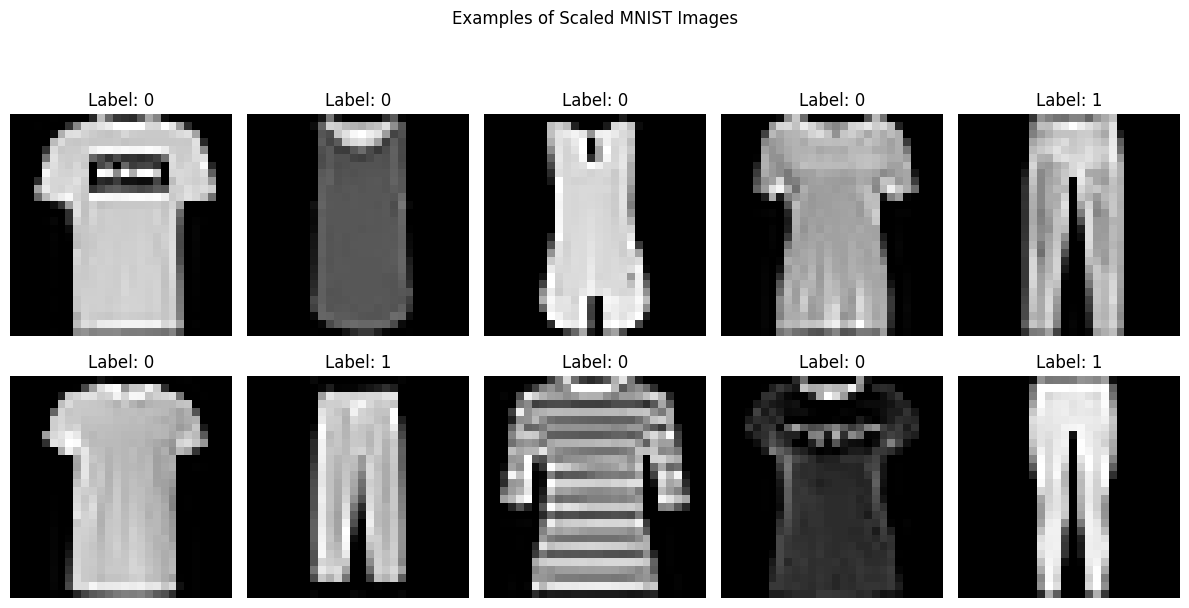

In [4]:
def read_mnist_images(filepath, scale=True):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')

        # Read image data
        raw_data = f.read()
        images = np.frombuffer(raw_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

        # Scale images to the range [0, 1]
        if scale:
            images = images.astype('float32') / 255.0

        return images

def read_mnist_labels(filepath):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')

        # Read label data
        raw_data = f.read()
        labels = np.frombuffer(raw_data, dtype=np.uint8)

        return labels

def filter_classes(images, labels, class_list):
    # Filter images and labels based on the class list
    mask = np.isin(labels, class_list)
    return images[mask], labels[mask]

def load_and_preprocess_mnist_images(image_filepath, label_filepath, class_list):
    # Load images and labels from file
    images = read_mnist_images(image_filepath)
    labels = read_mnist_labels(label_filepath)

    # Filter to keep only specified classes
    images_filtered, labels_filtered = filter_classes(images, labels, class_list)

    # Scale the images
    images_scaled = images_filtered.astype('float32') / 255.0

    return images_scaled, labels_filtered

# Define class labels
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
}

# File paths
train_images_filepath = 'train-images-idx3-ubyte'
train_labels_filepath = 'train-labels-idx1-ubyte'
test_images_filepath = 't10k-images-idx3-ubyte'
test_labels_filepath = 't10k-labels-idx1-ubyte'

# Load and preprocess dataset
train_images_scaled, train_labels_filtered = load_and_preprocess_mnist_images(train_images_filepath, train_labels_filepath, [0, 1])
test_images_scaled, test_labels_filtered = load_and_preprocess_mnist_images(test_images_filepath, test_labels_filepath, [0, 1])

# Add a 4th dimension to image input
train_images_scaled = np.expand_dims(train_images_scaled, axis=-1)
test_images_scaled = np.expand_dims(test_images_scaled, axis=-1)

# Shape of the scaled and filtered data
print("Train images shape:", train_images_scaled.shape)
print("Test images shape :", test_images_scaled.shape)

# Show 10 examples of scaled images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_scaled[i], cmap='gray')
    plt.title(f'Label: {train_labels_filtered[i]}')
    plt.axis('off')
plt.suptitle('Examples of Scaled MNIST Images', y=1.05)
plt.tight_layout()
plt.show()

Merged images shape: (14000, 28, 28, 1)
Merged labels shape : (14000,)


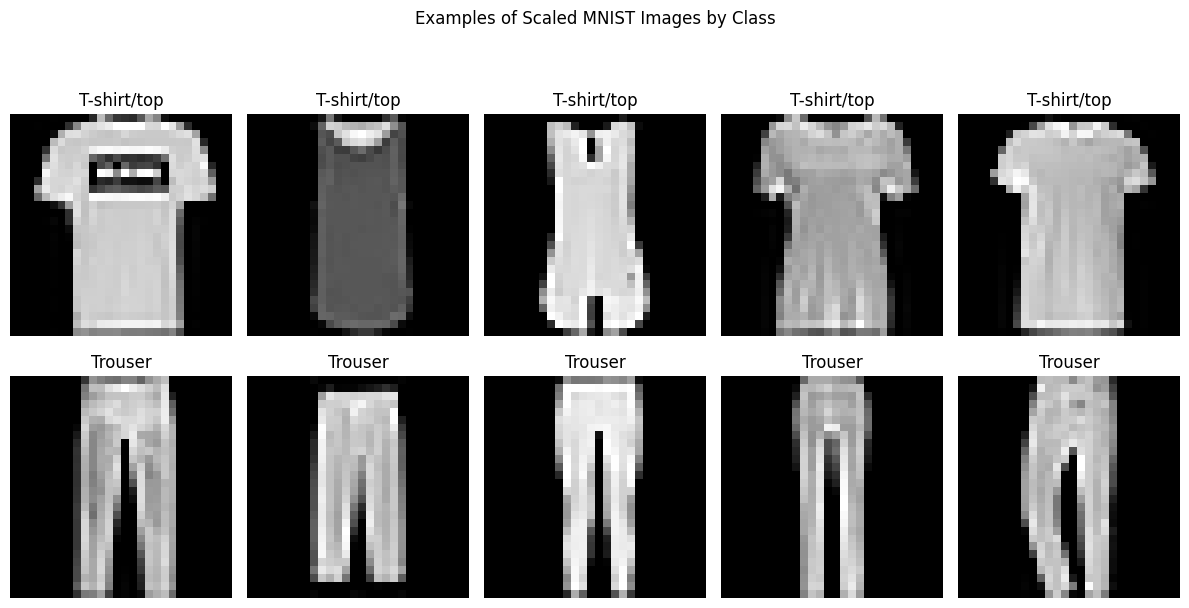

In [5]:
# Merge 'T-shirt/top' and 'Trouser' data from train and test sets
merged_images = np.concatenate((train_images_scaled, test_images_scaled), axis=0)
merged_labels = np.concatenate((train_labels_filtered, test_labels_filtered), axis=0)

# Shape of the scaled and filtered data
print("Merged images shape:", merged_images.shape)
print("Merged labels shape :", merged_labels.shape)

# Display 5 examples of 'T-shirt/top' and 5 examples of 'Trouser'
plt.figure(figsize=(12, 6))

# Plotting T-shirt images
tshirt_indices = np.where(merged_labels == 0)[0][:5]
for i, idx in enumerate(tshirt_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(merged_images[idx], cmap='gray')
    plt.title(class_labels[0])
    plt.axis('off')

# Plotting Trouser images
trouser_indices = np.where(merged_labels == 1)[0][:5]
for i, idx in enumerate(trouser_indices):
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(merged_images[idx], cmap='gray')
    plt.title(class_labels[1])
    plt.axis('off')

plt.suptitle('Examples of Scaled MNIST Images by Class', y=1.05)
plt.tight_layout()
plt.show()

In [6]:
merged_data = []
for img, lbl in zip(merged_images, merged_labels):
    merged_data.append({'image': img.flatten(), 'label': lbl})

merged_data_mnist = pd.DataFrame(merged_data)

# DataFrame
print(merged_data_mnist.head())

                                               image  label
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.5378702e-05, 0.0, ...      0
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00016916...      0
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      1


In [7]:
from sklearn.model_selection import train_test_split

X = merged_data_mnist.drop(columns=['label'])
y = merged_data_mnist['label']

X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.12, random_state=42)

# Reset index for consistency
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_val, y_val = X_val.reset_index(drop=True), y_val.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)


print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (9856, 1) (9856,)
Validation set shape: (1344, 1) (1344,)
Test set shape: (2800, 1) (2800,)


### Build Generator and Discriminator

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, ReLU, Embedding, multiply, Input, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
import numpy as np

# GAN parameters
latent_dim = 100  # dimension of noise input
img_shape = (28, 28, 1)  # shape of the image (28x28x1 for MNIST)
num_classes = 2 # number of classes in the dataset
batch_size = 128
epochs = 200

# Build Generator
def generator_Network():
    noise_input = Input(shape=(latent_dim,)) # input for noise with dimension latent_dim
    label_input = Input(shape=(1,), dtype='int32') # input for label with type int

    # Perform label embedding and flatten the result
    embedding_the_label = Flatten()(Embedding(num_classes, latent_dim)(label_input))
    # Combine noise and embedding label using multiplication operation
    input_Network = multiply([noise_input, embedding_the_label])

    # Build a Sequential model
    model = Sequential()
    model.add(Dense(1024, input_dim=latent_dim)) # first dense layer
    model.add(BatchNormalization()) # batch normalization for stabilization
    model.add(ReLU())  # Use ReLU
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))  # Dropout layer
    model.add(Dense(np.prod(img_shape), activation='sigmoid'))
    model.add(Reshape(img_shape))

    img = model(input_Network)

    return Model([noise_input, label_input], img)

# Build Discriminator
def discriminator_Network():
    images = Input(shape=img_shape) # input for images with shape img_shape
    label_input = Input(shape=(1,), dtype='int32') # input for label with type int

    # Perform label embedding and flatten the result
    embedding_the_label = Flatten()(Embedding(num_classes, np.prod(img_shape))(label_input))
    # Combine noise and embedding label using multiplication operation
    flatten_img = Flatten()(images)
    # Combine flattened image and embedding label using multiplication operation
    input_Network = multiply([flatten_img, embedding_the_label])

    x = Dense(1024)(input_Network) # first dense layer
    x = BatchNormalization()(x) # batch normalization for stabilization
    x = ReLU()(x)  # ReLU activation
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)  # Dropout layer for regularization
    validity = Dense(1, activation='sigmoid')(x)

    return Model([images, label_input], validity)


In [9]:
# Build Generator
generator = generator_Network()
print("Generator Summary:")
generator.summary()

# Build Discriminator
discriminator = discriminator_Network()
print("\nDiscriminator Summary:")
discriminator.summary()


Generator Summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 100)               200       ['input_4[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten (Flatten)           (None, 100)                  0         ['embedding[0][0]']           
                                                                           

In [10]:
from tensorflow.keras.optimizers import Adam
# Compile the discriminator
discriminator = discriminator_Network()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.00005, 0.5))

# The generator takes noise and the target label as input and generates the corresponding digit
noise = Input(shape=(latent_dim,))
label = Input(shape=(1,), dtype='int32')
img = generator([noise, label])

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
validity_discriminator = discriminator([img, label])

# The combined model (stacked generator and discriminator) takes noise and label as input => generates images => determines validity
gan_model_ = Model([noise, label], validity_discriminator)
gan_model_.compile(loss='binary_crossentropy', optimizer=Adam(0.00005, 0.5))

print("\nCombined Summary:")
gan_model_.summary()


Combined Summary:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 28, 28, 1)            968408    ['input_9[0][0]',             
                                                                     'input_10[0][0]']            
                                                                                                  
 model_2 (Functional)        (None, 1)                    1468961   ['mod

### Train GAN

4/4 [==============================] - 0s 3ms/step
Epoch:0, Step:0, D-Loss:0.746, G-Loss:0.693
4/4 [==============================] - 0s 2ms/step
Epoch:1, Step:1, D-Loss:0.788, G-Loss:0.688
4/4 [==============================] - 0s 2ms/step
Epoch:2, Step:2, D-Loss:0.680, G-Loss:0.685
4/4 [==============================] - 0s 3ms/step
Epoch:3, Step:3, D-Loss:0.618, G-Loss:0.685
4/4 [==============================] - 0s 2ms/step
Epoch:4, Step:4, D-Loss:0.655, G-Loss:0.683
4/4 [==============================] - 0s 3ms/step
Epoch:5, Step:5, D-Loss:0.629, G-Loss:0.679
4/4 [==============================] - 0s 3ms/step
Epoch:6, Step:6, D-Loss:0.598, G-Loss:0.681
4/4 [==============================] - 0s 3ms/step
Epoch:7, Step:7, D-Loss:0.523, G-Loss:0.668
4/4 [==============================] - 0s 3ms/step
Epoch:8, Step:8, D-Loss:0.507, G-Loss:0.676
4/4 [==============================] - 0s 3ms/step
Epoch:9, Step:9, D-Loss:0.538, G-Loss:0.667
4/4 [==============================] - 0s 2ms/step

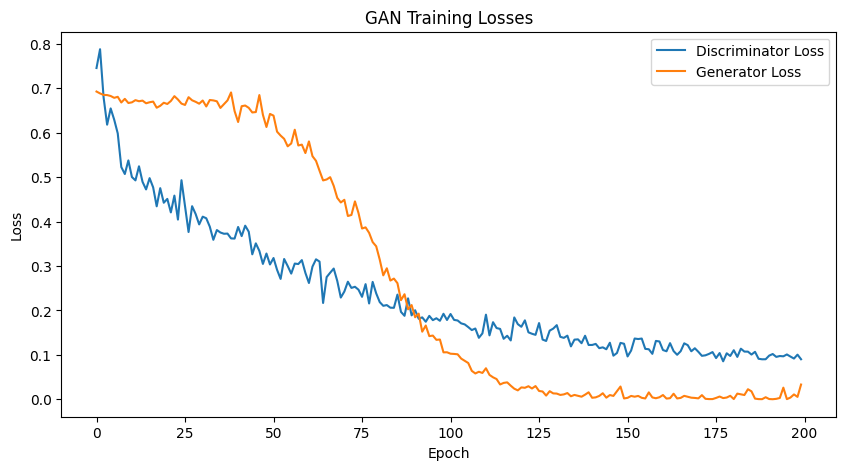

In [11]:
# Function to train GAN
sample_interval = 100
def train_gan_with_logging(X_train, y_train, epochs, batch_size=128, sample_interval=50):
    # Preprocess data into required shapes
    X_train = np.array([np.array(img).reshape(28, 28, 1) for img in X_train['image']])
    y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

    # Define valid and fake labels for discriminator
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    d_losses = [] # List to store discriminator losses
    g_losses = [] # List to store generator losses

    # Function to get random samples from training data
    def get_random_samples(batch_size):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        labels = y_train[idx]
        return imgs, labels

    # Function to generate noise and labels for generator input
    def generate_noise_labels(batch_size):
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        return noise, sampled_labels

    step = 0
    for epoch in range(epochs):
        for _ in range(2):  # Train discriminator more than generator
            imgs, labels = get_random_samples(batch_size)
            noise, sampled_labels = generate_noise_labels(batch_size)
            gen_imgs = generator.predict([noise, sampled_labels])

            # Train discriminator on real and fake data
            d_loss_real = discriminator.train_on_batch([imgs, labels], valid)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, sampled_labels], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise, sampled_labels = generate_noise_labels(batch_size)
        g_loss = gan_model_.train_on_batch([noise, sampled_labels], valid)

         # Append losses to lists
        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Compute discriminator accuracy if available
        d_acc = 100 * d_loss[1] if isinstance(d_loss, (tuple, list)) else None


         # Logging progress
        log_message = f"Epoch:{epoch}, Step:{step}, D-Loss:{d_loss[0] if isinstance(d_loss, (tuple, list)) else d_loss:.3f}, "
        if d_acc is not None:
            log_message += f"D-Acc:{d_acc:.3f}, "
        log_message += f"G-Loss:{g_loss:.3f}"
        print(log_message)

        step += 1

        if epoch % sample_interval == 0:
            sample_images(epoch)

    plot_losses(d_losses, g_losses)

def sample_images(epoch):
    # Generate noise and labels for sample images
    noise = np.random.normal(0, 1, (25, latent_dim))
    sampled_labels = np.random.randint(0, num_classes, 25).reshape(-1, 1)
    gen_imgs = generator.predict([noise, sampled_labels])
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot generated images in a grid
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    count = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            count += 1
    fig.suptitle(f"Generated Images at Epoch {epoch}", fontsize=16)
    fig.savefig(f"mnist_{epoch}.png")
    plt.close()

def plot_losses(d_losses, g_losses):
    # Plot discriminator and generator losses over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("GAN Training Losses")
    plt.show()

train_gan_with_logging(X_train, y_train, epochs, batch_size, sample_interval)

### Generate images using a trained generator model

In [12]:
def generate_images(generator_model, latent_dimension, num_classes, num_samples):
    noise_vector = np.random.normal(0, 1, (num_samples, latent_dimension))
    sampled_labels = np.random.randint(0, num_classes, num_samples).reshape(-1, 1)
    generated_images = generator.predict([noise_vector, sampled_labels])
    return generated_images

generated_images = generate_images(generator, latent_dim, num_classes, len(X_test))


88/88 [==============================] - 0s 2ms/step


### Prepare InceptionV3 model

In [13]:
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from skimage.transform import resize
from scipy.linalg import sqrtm
import pandas as pd

# Prepare InceptionV3 model
inception_v3_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def preprocess_images_for_inception(images_array):
    images_array = np.asarray(images_array, dtype=np.float32)  # Convert images to float32 numpy array
    images_array = np.repeat(images_array, 3, axis=-1)  # Repeat grayscale channel to match InceptionV3 input
    images_resized_array = np.array([resize(image, (299, 299, 3)) for image in images_array])
    images_resized_array = preprocess_input(images_resized_array)
    return images_resized_array

# Extract features from images
def extract_features(images_array, model, batch_size=32):
    n_samples = len(images_array)
    features_list = []
    for i in range(0, n_samples, batch_size):
        batch_images = images_array[i:i+batch_size] # reduce batch size as it may fail if run with a large batch size due to high RAM usage
        preprocessed_images = preprocess_images_for_inception(batch_images)
        features = model.predict(preprocessed_images)
        features_list.append(features)
    features_array = np.concatenate(features_list, axis=0)
    return features_array

# Calculate FID
def compute_fid(real_features_array, generated_features_array):
    mu_real, sigma_real = real_features_array.mean(axis=0), np.cov(real_features_array, rowvar=False)
    mu_gen, sigma_gen = generated_features_array.mean(axis=0), np.cov(generated_features_array, rowvar=False)
    ssdiff = np.sum((mu_real - mu_gen) ** 2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid_score = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid_score

# Load data
# X_test is assumed to be a dataframe with an 'image' column containing the image data as lists

# Convert dataframe column to numpy array
if isinstance(X_test, pd.DataFrame):
    X_test_image_array = np.array([np.array(img) for img in X_test['image'].values])
    X_test_image_array = X_test_image_array.reshape((-1, 28, 28, 1))  # Reshape to match the expected input

# Normalize and preprocess images
X_test_image_array = (X_test_image_array.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

# Generate images from the generator (replace with your actual generator function)
generated_image_array = generate_images(generator, latent_dim, num_classes, len(X_test))

# Get features for real and generated images
real_features_array = extract_features(X_test_image_array, inception_v3_model)
generated_features_array = extract_features(generated_image_array, inception_v3_model)

# Calculate FID
fid_score = compute_fid(real_features_array, generated_features_array)
print('FID:', fid_score)


1/1 [==============================] - 0s 39ms/step
FID: 2.4560637871597493


The result with a Frechet Inception Distance (FID) score of 2.4560637871597493 indicates that the images generated by the Generator in the GAN model are still of suboptimal quality and not very similar to the original images in the dataset, as the score is not close to 0. However, this result of 2.45 shows that the GAN model is quite efficient in producing better quality images.